# Introduction

The goal of this project is to apply Bayesian methods to a real-world application. I have always been interested in transportation dynamics, and this is my attempt to model two of the most sophisticated transportation systems in New York - taxis rides. Fortunately, yellow cab data is very clearly documented, which I will outline below. 

# Modeling Dynamics of Taxi Rides in Manhattan

Taxi rides constitute an extremely dynamic and complicated system.  Unlike the subway system, which has pre-defined destinations and departures, a taxi rides can go from any location to any other location. As a result, several key assumptions will need to be made in order to make any sort of profound insight.

# Part 1A: Retrieving Taxi Data

The following function grabs all taxi rides between a certain time. The url_heads will vary based on the year that we are retrieving.

In [7]:
import urllib
import json
import pandas as pd
from datetime import datetime

def getTaxiData(datebegin,dateend):
    limit = 50000
    master = pd.DataFrame()
    offset = 0
    #if offset % 500000 == 0:
        #print offset
    while(True):
        url_head = "https://data.cityofnewyork.us/resource/gkne-dk5s.json?"
        #url_head = "https://data.cityofnewyork.us/resource/t7ny-aygi.json?"
        text_limit = "$limit="+str(limit)+"&"
        text_offset = "$offset="+str(offset)+"&"
        text_time = "$where=pickup_datetime between " + "'" + datebegin + "' and '" + dateend + "'"
        #text_time = "$where=tpep_pickup_datetime between " + "'" + datebegin + "' and '" + dateend + "'"

        url = url_head + text_limit + text_offset + text_time
        text = urllib.urlopen(url).read()
        data = pd.DataFrame(json.loads(text))
        master = master.append(data)
        offset += limit
        if(data.shape[0] < limit):
            break
    return master

# Part 1B: Retrieving Geographic Data - Census Tracts

In order to perform any kind of meaningful analysis, it is important to group the taxi pickups to different regions of the city. For this project, we choose to focus on Manhattan. We considered using zip codes, but zip codes don't exactly have a geographic boundary to them - they are, after all, just routes that help get mail transferred more efficiently. Instead, we used census tracts (as described from the 2010 census) to split Manhattan into 288 distinct regions.

In [8]:
with open('NYC_Census_Tracts_2010.json') as data_file:
    json_data = json.load(data_file)

To help with out search, we also found the minimum x and y coordinates of each of the census tracts, which are described as points ina polygon. This will help us allocate taxi pickups to certain regions much more efficiently.

In [39]:
all_tracts = dict()
min_y = dict()
min_x = dict()
max_y = dict()
max_x = dict()
for tract in json_data['features']:
    if tract['properties']['BoroName'] == 'Manhattan':
        if len(tract['geometry']['coordinates'][0][0]) != 2:
            all_tracts[tract['id']] = tract['geometry']['coordinates'][0][0]
        else:
            all_tracts[tract['id']] = tract['geometry']['coordinates'][0]
        min_y[tract['id']] = min([pts[1] for pts in all_tracts[tract['id']]])
        max_y[tract['id']] = max([pts[1] for pts in all_tracts[tract['id']]])
        min_x[tract['id']] = min([pts[0] for pts in all_tracts[tract['id']]])
        max_x[tract['id']] = max([pts[0] for pts in all_tracts[tract['id']]])

# Part 2: Allocating Taxi Pickups to Census Tracts

With both taxi logs and census tract data in hand, we can translate the latitudes and longitudes associated with each taxi pickup to a particular census tract. point_inside_polygon is the function that determines whether a lat-long point belongs in a census tract or not.

In [9]:
def point_inside_polygon(x,y,poly):
    """Return True if the point described by x, y is inside of the polygon
    described by the list of points [(x0, y0), (x1, y1), ... (xn, yn)] in
    ``poly``
    Code from http://www.ariel.com.au/a/python-point-int-poly.html which
    in turn was adapted from C code found at
    http://local.wasp.uwa.edu.au/~pbourke/geometry/insidepoly/
    """
    n = len(poly)
    inside =False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xinters = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x,p1y = p2x,p2y

    return inside

The function findCensusTract uses the point_inside_polygon to find the right census tract. Here, the min-max coordinates of each census tracts help us eliminate the need to even use the point_inside_polygon function when appropriate, thereby reducing computational time.

In [10]:
def findCensusTract(x,y):
    for key,val in all_tracts.iteritems():
        if min_x[key] <= x and min_y[key] <= y and max_x[key] >= x and max_y[key] >= y:
            if point_inside_polygon(x,y,val):
                return key
    return None

# Part 3: Getting a Year Worth of Data

The following scripts retrieve a years worth of data and counts the number of taxi pickups for a given hour and census tract. This is the most time-consuming part of the data collection process. These are all pickled into files, each of which contain daily data.

In [9]:
def getCleanTaxiData(day,day2):
    data = getTaxiData(day, day2)
    if len(data) == 0:
        return data
    longitudes = [float(x) for x in data['pickup_longitude']]
    latitudes = [float(x) for x in data['pickup_latitude']]
    data['pickup_census_tract'] = [findCensusTract(x,y) for x,y in zip(longitudes,latitudes)]
    data['pickup_datetime'] = [datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f') for x in data['pickup_datetime']]
    return data

In [5]:
from datetime import date, timedelta as td
d1 = date(2014,1,1)
d2 = date(2014,12,31)
delta = d2 - d1
all_dates = [date.isoformat(d1 + td(days=i)) for i in range(delta.days + 1)]
for day in all_dates:
    hours = range(0,24)
    df = pd.DataFrame([getCleanTaxiData(day+'T'+str(hr)+':00:00',day+'T'+str(hr)+':59:59')
                       .groupby(['pickup_census_tract']).count()['tpep_dropoff_datetime']
                      for hr in hours]).T
    df.columns = hours
    df.to_pickle('Taxi Data/'+day)
    print day + ' Complete'

When we ran the script we notice that the early morning of March 9th did not have any taxi pickups at all. We then realized that this was because daytime savings time occured during those hours! We did a quick check on the early morning of November 2nd and found that pickups were twice the amount as usual! In order to compensate for this anomaly, we halved the November 2nd pickups number and assigned the March 9th data to have the same pickup counts.

In [48]:
# Deal With Daylight Savings Time
import numpy as np
test_nov = pd.read_pickle('Taxi Data/2014-11-02')
test_mar = pd.read_pickle('Taxi Data/2014-03-09')
half = test_nov[2].values/2
test_nov[2] = half
test_mar[2] = half
test_nov[2] = [int(round(x)) if not np.isnan(x) else 0 for x in test_nov[2].values]
test_mar[2] = [int(round(x)) if not np.isnan(x) else 0 for x in test_mar[2].values]
test_nov.to_pickle('Taxi Data/2014-11-02')
test_mar.to_pickle('Taxi Data/2014-03-09')

# Part 4: Converting Data into Bayesian Model Form

Before we implement the Bayesian model, we have to convert all this yearly data into a nested list by hour, by census, then by data points. The following scripts retrieves the pickled files, which are organized daily, and puts all the counts into one big nested list.

In [57]:
from copy import deepcopy
d1 = date(2014,1,1)
d2 = date(2014,12,31)
delta = d2 - d1
string_dates = [date.isoformat(d1 + td(days=i)) for i in range(delta.days + 1)]
all_dates = [d1+td(days=i) for i in range(delta.days + 1)]

num_h = 168
num_c = 288
num_w = len(all_dates)/7
num_d = num_w * 7

x_data = [[[] for c in range(0,num_c)] for h in range(0,num_h)]
i = 0
count = 0
for string_day, day in zip(string_dates,all_dates):
    data = pd.read_pickle('Taxi Data/'+string_day)
    data = data.fillna(0)
    weekday = day.weekday()
    for c,tract in enumerate(all_tracts.keys()):
        for h in range(0,24):
            if tract in data.index:  
                x_data[weekday*24+h][c].append(int(data[h][tract]))
            else:
                x_data[weekday*24+h][c].append(0)
    i = i + 1
    if i >= num_d:
        break

# Part 5: Exploratory Analysis

Before we implement the Bayesian model, we also can do some quick exploratory analysis of the data just to get a sense of how pickups change over time or across different census tracts.

# Part 5A: Across Census Tracts

The following code looks at how taxi pickups differ across census tracts at a particular hour of a particular day. The variable data can be obtained from one of the pickled files.

The following code looks at how taxi pickups differ across census tracts at a particular hour of a particular day. The variable data can be obtained from one of the pickled files.

In [1]:
def draw_screen_poly(lats, lons, alpha):
    xy = zip(lons,lats)
    poly = Polygon( xy, facecolor=(1,0,0), alpha=alpha )
    plt.gca().add_patch(poly)

In [297]:
import math

def plotFreqMap(census_counts,all_tracts,max_count,hour):
    for key,val in all_tracts.iteritems():
        if key not in census_counts:
            alpha = 0.2
        else:
            alpha = 0.2+0.8*census_counts[key]/max_count
        draw_screen_poly([x[1] for x in val], [x[0] for x in val],alpha)

    floor = math.floor(math.log10(max_count))
    pct = [0,0.1, 0.2, 0.5, 1]
    shades = [int(round(1.*max_count*x/(10**floor))*(10**floor)) if x != 1 
              else int(math.floor(1.*max_count*x/(10**floor))*(10**floor)) for x in pct]
    
    idx = 0
    for shadeb,shade in zip(shades[:-1],shades[1:]):
        idx = idx + 1
        if shade == shadeb:
            shades[idx] = int(shade + (10**floor))

    l = [plt.scatter([],[], s=25, color = (1,0,0),alpha=0.2+0.8*x/max_count) for x in shades]
    labels = [str(x)[:-3]+','+str(x)[-3:] if len(str(x)) > 3 else str(x) for x in shades]

    leg = plt.legend(l, labels, ncol=1, frameon=True, fontsize=10,
    handlelength=0.5, loc = 2, borderpad = 1.8,
    handletextpad=1,title = 'Taxi Rides\n', scatterpoints = 1,prop=fontP)

    time_edit = hour % 12
    if time_edit == 0:
        time_edit = time_edit + 12
    if hour < 12:
        time_edit = str(time_edit) + ' AM'
    else:
        time_edit = str(time_edit) + ' PM'
        
    plt.xlim(-74.07,-73.88)
    plt.ylim(40.67,40.90)
    plt.title('Taxi Pickup Activity in Manhattan at ' + time_edit + '\n', fontsize=17)

In [294]:
def plotHourlyFreq(all_census_counts,all_tracts,hour):
    max_count = max([max([val for key,val in hour_data.iteritems()]) for hour_data in all_census_counts])
    plotFreqMap(all_census_counts[hour],all_tracts,max_count,hour)

In [264]:
numHours = 24
all_census_counts = [dict(zip(all_tracts.keys(),[0]*len(all_tracts.keys()))) for x in range(0,numHours)]
for index,row in data.iterrows():
    if not math.isnan(row['pickup_census_tract']):
        all_census_counts[row['pickup_datetime'].hour][row['pickup_census_tract']] = 
        all_census_counts[row['pickup_datetime'].hour][row['pickup_census_tract']]+1
                    

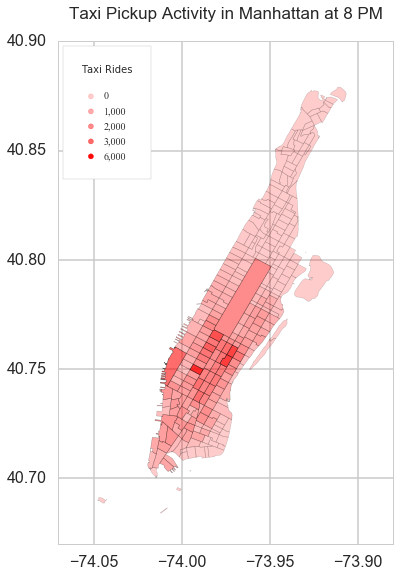

In [300]:
plotHourlyFreq(all_census_counts,all_tracts,20)

# Part 5B: Across Hours of Day

The following code plots taxi pickups by particular hours of the day, either for the entire Manhattan or for a particular census tract. We can see in these graphs that the distribution on Monday through Friday and Saturday through Sunday are similar among each other, but not compared to each other, which justifies the Bayesian model we seek to implement.

In [146]:
def plotHourlyDataTract(data,date,date2,census_tract):
    dayofWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    times = range(4,24) + range(0,4)
    counts = [len(data[(data['pickup_datetime'] >= date + ' ' + str(time) + ':00:00') & \
                       (data['pickup_datetime'] <= date + ' ' + str(time) + ':59:59') & \
                       (data['pickup_census_tract'] == census_tract)]) if time >= 4 else \
              len(data[(data['pickup_datetime'] >= date2 + ' ' + str(time) + ':00:00') & \
                       (data['pickup_datetime'] <= date2 + ' ' + str(time) + ':59:59') & \
                       (data['pickup_census_tract'] == census_tract)]) for time in times]
    rcParams['figure.figsize'] = 12, 6
    labels = [str(x % 12) + ' AM' if x < 12 else str(x % 12) + ' PM' for x in times]
    labels = [y if x % 3 == 1 else "" for x,y in zip(times,labels)]
    plt.bar(range(0,24),counts,tick_label = labels)
    plt.title('NYC Taxi Rides for ' + dayofWeek[datetime.strptime(date,'%Y-%m-%d').weekday()] + ', ' 
              + date + ', Census Tract ' + str(census_tract) + '\n')
    plt.show()

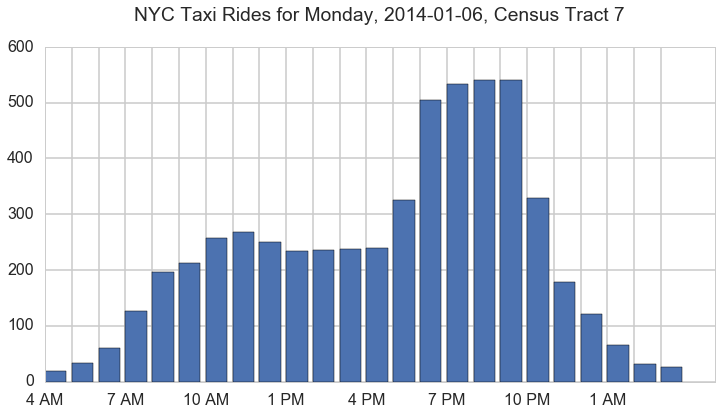

In [155]:
plotHourlyDataTract(all_data[0],'2014-01-06','2014-01-07',7)

In [119]:
def plotHourlyData(data,date,date2):
    dayofWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    times = range(4,24) + range(0,4)
    counts = [len(data[(data['pickup_datetime'] >= date + ' ' + str(time) + ':00:00') & \
                       (data['pickup_datetime'] <= date + ' ' + str(time) + ':59:59')]) if time >= 4 else \
              len(data[(data['pickup_datetime'] >= date2 + ' ' + str(time) + ':00:00') & \
                       (data['pickup_datetime'] <= date2 + ' ' + str(time) + ':59:59')]) for time in times]
    rcParams['figure.figsize'] = 10, 6
    labels = [str(x % 12) + ' AM' if x < 12 else str(x % 12) + ' PM' for x in times]
    labels = [y if x % 3 == 1 else "" for x,y in zip(times,labels)]
    plt.bar(range(0,24),counts,tick_label = labels)
    plt.title('NYC Taxi Rides for ' + dayofWeek[datetime.strptime(date,'%Y-%m-%d').weekday()] + ', ' + date + ', by Hour\n')
    plt.show()

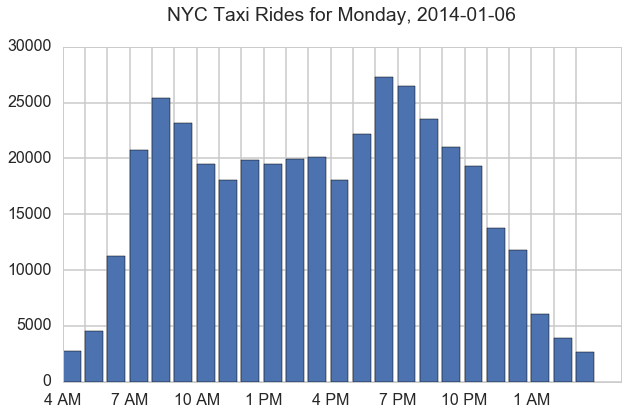

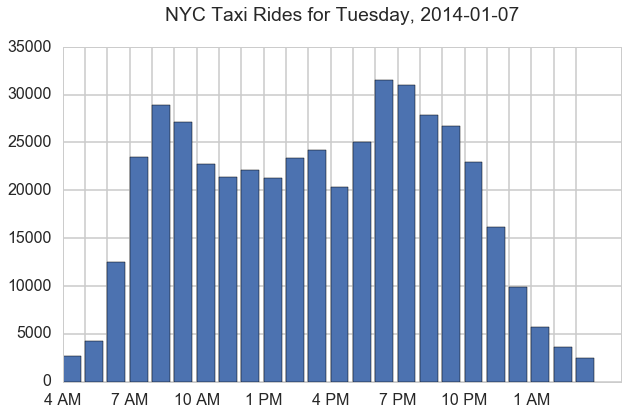

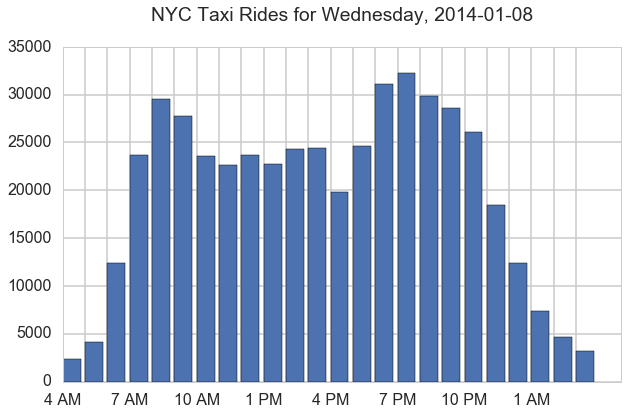

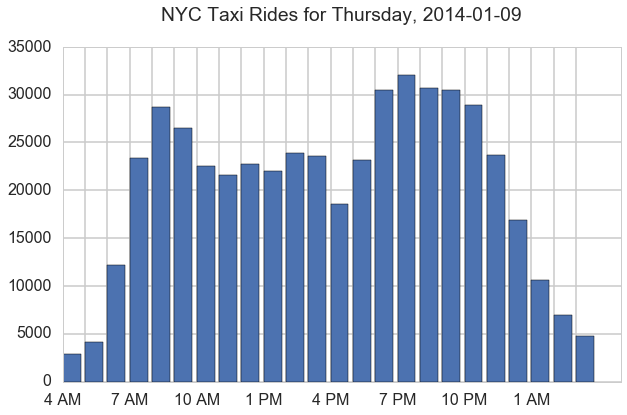

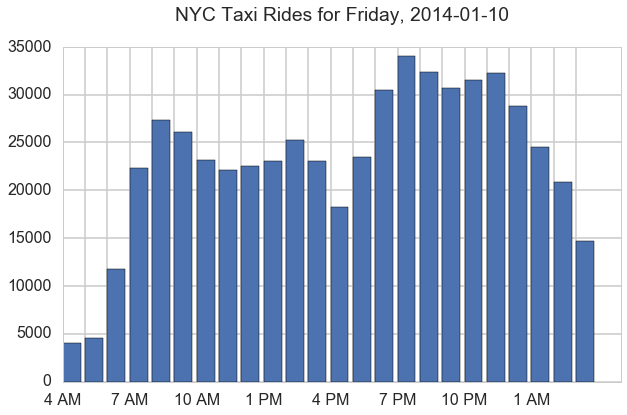

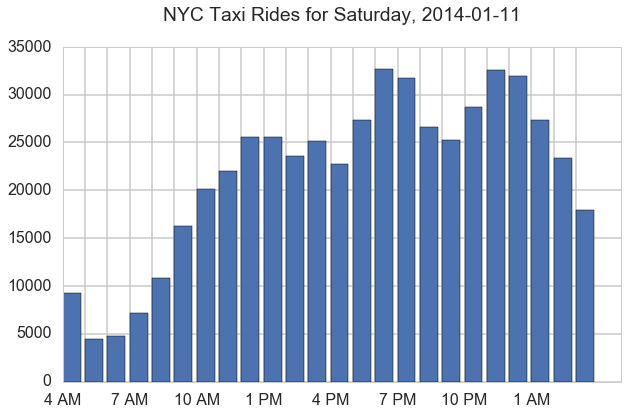

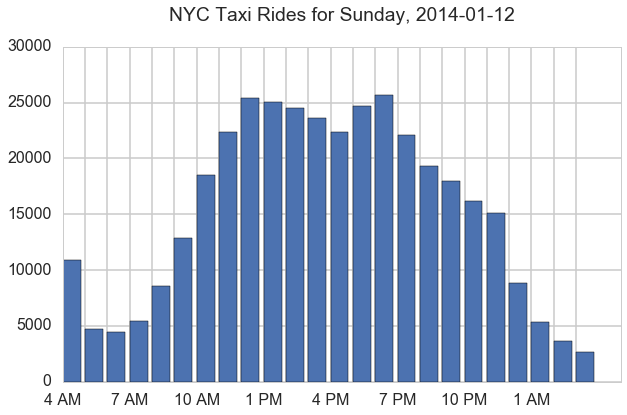

In [121]:
days = ['2014-01-06','2014-01-07','2014-01-08','2014-01-09','2014-01-10','2014-01-11','2014-01-12','2014-01-13']
for data,datebegin,dateend in zip(all_data,days[:-1],days[1:]):
    plotHourlyData(data,datebegin,dateend)

# Part 6A: Creating the Gibbs Sampler

Finally we implement the Bayesian model by building the Gibbs sampler that simulates the distribution of hte parameters. These distributions are implemented using the closed-form solutions of posterior conditionals derived in the Taxi Modeling PDF write-up. See that document for more details.

In [9]:
def GibbSampler(x_data,list_alpha,list_a,p,q,num_iterations,cutoff):
    num_z = 24 * 2
    num_h = 24 * 7
    num_c = 288
    
    # Initialize Variables
    list_b = np.random.gamma(p,1./q, size = num_z)
    list_beta = [np.random.gamma(list_a[mapHourToGroup(h)],1./list_b[mapHourToGroup(h)],size=1)[0]
                 for h in range(0,num_h)]
    list_lambda = [[np.random.gamma(list_alpha[h][c],1./list_beta[h],size=1)[0] for c in range(0,num_c)]
                   for h in range(0,num_h)]
    
    x_means = [[sum(x_data[h][c]) for c in range(0,num_c)] for h in range(0,num_h)]
    
    b_data = [list_b]
    beta_data = [list_beta]
    lambda_data = [list_lambda]
    
    # Perform Updating Algorithm
    for i in range(0,num_iterations):
        if i % 50 == 0:
            print i   
        list_lambda = [[np.random.gamma(list_alpha[h][c] + x_means[h][c], 
                                        1./(len(x_data[h][c]) + list_beta[h]),size = 1)[0] 
                        for c in range(0,num_c)] for h in range(0,num_h)]  
        list_beta = [np.random.gamma(list_a[mapHourToGroup(h)] + sum(list_alpha[h]), 
                                     1./(list_b[mapHourToGroup(h)] + sum(list_lambda[h])), size = 1)[0] 
                     for h in range(0,num_h)]
        list_b = [np.random.gamma(p + len(mapGroupToHours(z))*list_a[z], 
                                  1./(q + sum([list_beta[idx] for idx in mapGroupToHours(z)])), size = 1)[0] 
                  for z in range(0,num_z)]
              
        if i >= cutoff:
            b_data.append(list_b)
            beta_data.append(list_beta)
            lambda_data.append(list_lambda)
    
    return b_data,beta_data,lambda_data 
    

In [10]:
def mapHourToGroup(hour):
    if hour >= 24 * 5:
        return 24 + hour % 24
    else:
        return hour % 24

In [11]:
def mapGroupToHours(group):
    if group < 24:
        return [x*24+group%24 for x in range(0,5)]
    else:
        return [x*24+group%24 for x in range(5,7)]

# Part 6B: Testing the Gibbs Sampler

To test the accuracy of the Gibbs sampler, we generated fake data using known parameters. Here we set all the a's are 1, all the alpha's are 2, and p and q are 1 and 2 respectively. This generates the parameters b, beta, lambda, which we compared the simulated values of these parameters to and see if they are in line with the true parameters that we originally generated.

In [354]:
# Test Script to Check if Gibbs Sampler Works
num_z = 24 * 2
num_h = 24 * 7
num_c = 288
p = 1
q = 2
list_a = [1] * num_z
list_alpha = [[2]*num_c]*num_h
n = 1000

# Simulate x_data based on these parameters
list_b = np.random.gamma(p,1./q, size = num_z)
list_beta = [np.random.gamma(list_a[mapHourToGroup(h)],1./list_b[mapHourToGroup(h)],size=1)[0] 
             for h in range(0,num_h)]
list_lambda = [[np.random.gamma(list_alpha[h][c],1./list_beta[h],size=1)[0] for c in range(0,num_c)]
                for h in range(0,num_h)]
x_data = [[np.random.poisson(lam = list_lambda[h][c], size = n) for c in range(0,num_c)] for h in range(0,num_h)]
b_data,beta_data,lambda_data = GibbSampler(x_data,list_alpha,list_a,p,q,1200,200)

The following code tests whether the parameters reach covergence after a certain number of simulations. Notice that these simulated values reach convergence very quickly.

In [344]:
def plotConvergence(data,original,idx1,idx2,cutoff,end):
    if type(idx1) == int and type(idx2) == int:
        plt.plot(range(0,end-cutoff),[x[idx1] for x in data[cutoff:end]],'b-')
        plt.plot(range(0,end-cutoff),[original[idx1]]*(end-cutoff),'b-')
        plt.plot(range(0,end-cutoff),[x[idx2] for x in data[cutoff:end]],'b-')
        plt.plot(range(0,end-cutoff),[original[idx2]]*(end-cutoff),'b-')
        plt.show()
    elif len(idx1) == len(idx2) and len(idx1) == 2:
        plt.plot(range(0,end-cutoff),[x[idx1[0]][idx1[1]] for x in data[cutoff:end]],'b')
        plt.plot(range(0,end-cutoff),[original[idx1[0]][idx1[1]]]*(end-cutoff),'b-')
        plt.plot(range(0,end-cutoff),[x[idx2[0]][idx2[1]] for x in data[cutoff:end]],'b')
        plt.plot(range(0,end-cutoff),[original[idx2[0]][idx2[1]]]*(end-cutoff),'b-')
        plt.show()

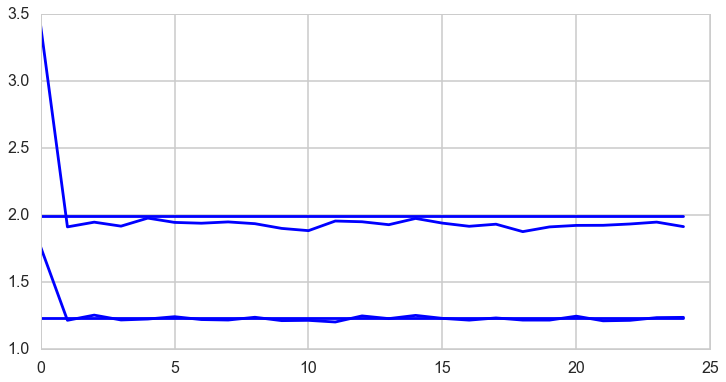

In [421]:
plotConvergence(beta_data,list_beta,5,29,0,25)

The following code tests two posterior distributions and test whether the simulated parameter values matched the true underlying value and whether the distributions are significantly different from each other if the unerlying values are different. This test has been applied to beta, b and lambda distributions and they appear to work well, thereby validating our implementation.

In [154]:
def hourToString(hr):
    hr_day = hr % 24
    if hr_day == 0:
        hr_day = hr_day + 12
    if hr_day <= 12:
        return str(hr_day) + ' AM'
    else:
        return str(hr_day - 12) + ' PM'

In [397]:
def compareTwoPosteriors(data,original,idx1,idx2,cutoff,title):
    dayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    typeDays = ['Weekday','Weekend']
    num_h = 24 * 7
    num_z = 24 * 2
    
    if type(idx1) == int and type(idx2) == int:
        plt.hist([x[idx1] for x in data[cutoff:]],bins=50,color='b')
        plt.axvline(x=original[idx1],linewidth=2, color='orange')
        plt.hist([x[idx2] for x in data[cutoff:]],bins=50,color='g')
        plt.axvline(x=original[idx2],linewidth=2, color='red')
        if len(original) == num_h:
            plt.title('Posterior Distribution of ' + title + ' for ' + dayOfWeek[int(idx1/24)] + ' ' + hourToString(idx1)
                      + ' and ' + dayOfWeek[int(idx2/24)] + ' ' + hourToString(idx2) + '\n')
        if len(original) == num_z:
            plt.title('Posterior Distribution of ' + title + ' for ' + typeDays[int(idx1/24)] + ' ' + hourToString(idx1)
                      + ' and ' + typeDays[int(idx2/24)] + ' ' + hourToString(idx2) + '\n')
    elif len(idx1) == len(idx2) and len(idx1) == 2:
        plt.hist([x[idx1[0]][idx1[1]] for x in data[cutoff:]],bins=50,color='b')
        plt.axvline(x=original[idx1[0]][idx1[1]],linewidth=2, color='orange')
        plt.hist([x[idx2[0]][idx2[1]] for x in data[cutoff:]],bins=50,color='g')
        plt.axvline(x=original[idx2[0]][idx2[1]],linewidth=2, color='red')
        plt.title('Posterior Distribution of ' + title + ' for ' + dayOfWeek[int(idx1[0]/24)] + ' ' + hourToString(idx1[0])
                  + ', Census ' + str(idx1[1]) + '\n and ' + dayOfWeek[int(idx2[0]/24)] + ' ' + hourToString(idx2[0])
                  + ', Census ' + str(idx2[1]) + '\n')    
    plt.show()

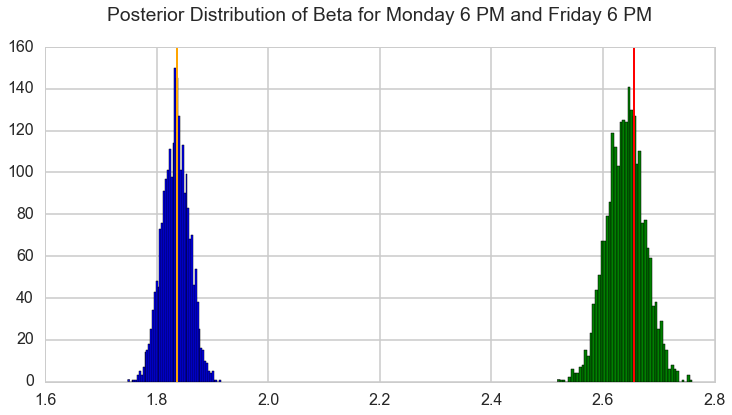

In [418]:
compareTwoPosteriors(beta_data,list_beta,18,114,200, 'Beta')

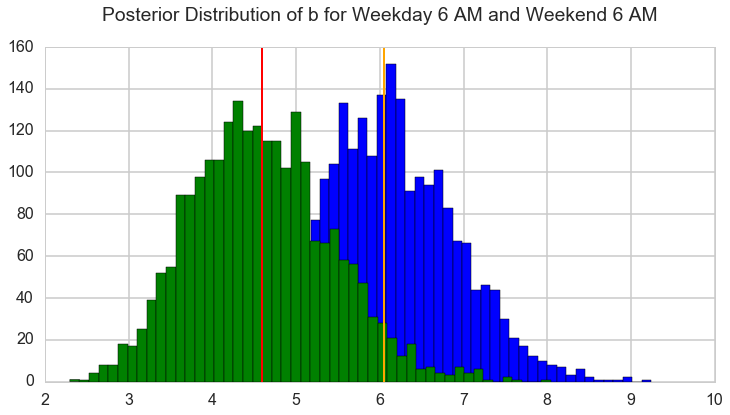

In [403]:
compareTwoPosteriors(b_data,list_b,6,30,200, 'b')

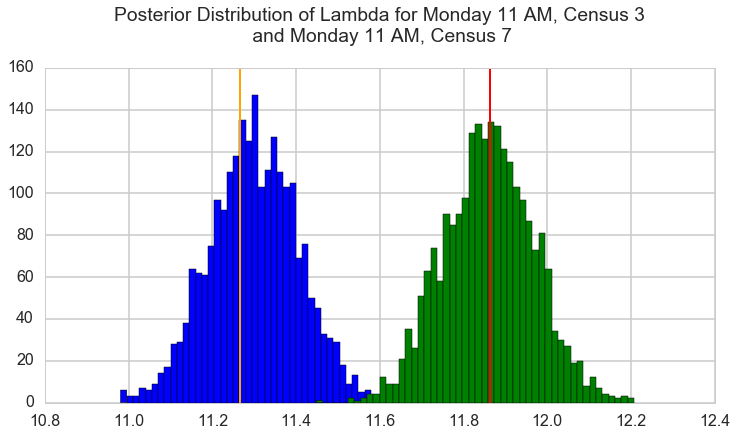

In [402]:
compareTwoPosteriors(lambda_data,list_lambda,(11,3),(11,7),200,'Lambda')

# Part 6C: Running the Gibbs Sampler on Real Data

Having tested the Gibbs Sampler, we can run the sampler on the data we cleaned in Part 4. The initial parameters p, q, a and alphas were based on intuition and general observations of the data. If I had more time, I would have made these selections more quantitatively based.

In [2]:
import numpy as np
num_z = 24 * 2
num_h = 24 * 7
num_c = 288
p = 20
q = 4
list_a = [1] * num_z
beta_estimate = 1.*list_a[0]/(1.*p/q)
means = [[np.mean(mini) for mini in hour_data] for hour_data in x_data]
list_alpha = [[k*beta_estimate if k > 0 else 0.00001 for k in h] for h in means]
b_data,beta_data,lambda_data = GibbSampler(x_data,list_alpha,list_a,p,q,1200,200)

# Part 7: Visualizing Taxi Demand in NYC

Finally, with all the parameters calibrated through the Bayesian model, we set forth to visualize the data.

In [9]:
all_tracts = dict()
min_y = dict()
min_x = dict()
max_y = dict()
max_x = dict()
for tract in json_data['features']:
    if tract['properties']['BoroName'] == 'Manhattan':
        if len(tract['geometry']['coordinates'][0][0]) != 2:
            all_tracts[tract['properties']['NTAName'] + ' (' + tract['properties']['CTLabel'] + ')'] = \
            tract['geometry']['coordinates'][0][0]
        else:
            all_tracts[tract['properties']['NTAName'] + ' (' + tract['properties']['CTLabel'] + ')'] = \
            tract['geometry']['coordinates'][0]
        min_y[tract['properties']['NTAName'] + ' (' + tract['properties']['CTLabel'] + ')'] = \
        min([pts[1] for pts in all_tracts[tract['properties']['NTAName'] + ' (' + tract['properties']['CTLabel'] + ')']])
        max_y[tract['properties']['NTAName'] + ' (' + tract['properties']['CTLabel'] + ')'] = \
        max([pts[1] for pts in all_tracts[tract['properties']['NTAName'] + ' (' + tract['properties']['CTLabel'] + ')']])
        min_x[tract['properties']['NTAName'] + ' (' + tract['properties']['CTLabel'] + ')'] = \
        min([pts[0] for pts in all_tracts[tract['properties']['NTAName'] + ' (' + tract['properties']['CTLabel'] + ')']])
        max_x[tract['properties']['NTAName'] + ' (' + tract['properties']['CTLabel'] + ')'] = \
        max([pts[0] for pts in all_tracts[tract['properties']['NTAName'] + ' (' + tract['properties']['CTLabel'] + ')']])

# Part 7A: All of Manhattan by Hour of Week

This visualization produces an interactive map of Manhattan that compares hourly taxi pickups in different regions. You can toggle the hour of the week to see how these comparisons change.  

In [46]:
from bokeh.models.widgets import Select,Dropdown,VBox
from bokeh.io import output_file, show, vform
from bokeh.models import HoverTool, CustomJS
from bokeh.plotting import figure, show, ColumnDataSource, cursession, output_server
from bokeh.io import output_notebook, hplot
from bokeh.embed import notebook_div
from bokeh.resources import CDN
from bokeh.embed import file_html

import math
import time
colors = ["#6666ff", "#4d4dff","#3333ff", "#1a1aff", "#0000cc", "#0000b3", "#000080","#00004d"]

hours = 24
clock = 12
hour_times = [x % clock + (x % clock == 0)*clock for x in range(0,hours)]
hour_times[:clock] = [str(x) + " AM" for x in hour_times[:clock]]
hour_times[clock:] = [str(x) + " PM" for x in hour_times[clock:]]

days = 7
neighborhoods = []
neigh_xs = []
neigh_ys = []
demand_full = []
neigh_colors_full = []

daysOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
keys = []
for neighborhood, data in all_tracts.iteritems():
    neigh_xs.append([x[0] for x in data])
    neigh_ys.append([x[1] for x in data])
    neighborhoods.append(neighborhood)
for day in range(0,days):
    for houridx,hour in enumerate(hour_times):
        keys += [daysOfWeek[day] + " " + hour]
        demand_rates = []
        for idx, neighborhood in enumerate(all_tracts.keys()):
            demand_points = np.mean([lambda_data[i][day*24+houridx][idx] for i in range(0,len(lambda_data))])
            demand_rates.append(demand_points)

        neigh_colors_full.append([colors[int(math.floor(i/max(demand_rates)/1.001*len(colors)))] for i in demand_rates])
        demand_full.append(demand_rates)

key_demand = [x + '_demand' for x in keys]
key_color = [x + '_color' for x in keys]

full_keys = key_color + key_demand + ['current_color','current_demand','neighborhoods','xs','ys']
full_values = neigh_colors_full + demand_full + \
              [neigh_colors_full[0],demand_full[0],neighborhoods,neigh_xs,neigh_ys]


source = ColumnDataSource(data=dict(zip(full_keys,full_values)))
source2 = ColumnDataSource(data=dict(day='Monday',hour='12 AM'))

TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save"
p = figure(title="Taxi Pickups per Hour",title_text_font_size='14pt',tools=TOOLS,plot_width=450,plot_height=650)
  
p.patches('xs', 'ys', source=source,
              fill_color='current_color', fill_alpha=0.7,
              line_color="white", line_width=0.5, name = 'patch')

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Neighborhood", "@neighborhoods"),
    ("Taxi Pickups", "@current_demand")
]

callback = CustomJS(args=dict(source=source,source2=source2), code="""
        var data = source.get('data');
        var data2 = source2.get('data');
        var f = cb_obj.get('value')
        var hour = data2['hour']
        data2['day'] = f
        data['current_color'] = data[f+' '+ hour + '_color']
        data['current_demand'] = data[f+' '+ hour + '_demand']
        source.trigger('change');
        source2.trigger('change');
    """)

callback2 = CustomJS(args=dict(source=source,source2=source2), code="""
        var data = source.get('data');
        var data2 = source2.get('data');
        var f = cb_obj.get('value')
        var day = data2['day']
        data2['hour'] = f
        data['current_color'] = data[day + ' ' + f + '_color']
        data['current_demand'] = data[day + ' ' + f + '_demand']
        source.trigger('change');      
        source2.trigger('change');
    """)

selectionDay = Select(value='Monday', options=daysOfWeek,callback=callback)
selectionHour = Select(value='12 AM', options=hour_times,callback=callback2)
menu_bar = hplot(VBox(selectionDay), VBox(selectionHour))
layout = vform(menu_bar, p)
output_file("Taxi_pickups_hourly_time.html", 
                title="Taxi_pickups_hourly_time.py")
show(layout)
    
html = file_html(layout, CDN, "my plot")


# Part 7B: Census Tract Taxi Pickups Over the Course of the Week

This interactive shows the hourly pickups of a particular census tract over the course of the week in one circular graph.

In [51]:
from bokeh.models.widgets import Select,Dropdown,VBox
from bokeh.io import output_file, show, vform
from bokeh.embed import components
from bokeh.session import Session
from bokeh.embed import autoload_server
from bokeh.plotting import figure, show, ColumnDataSource, cursession, output_server
from bokeh.models import HoverTool, CustomJS

width = 800
height = 800
inner_radius = 90
outer_radius = 300 - 10
rounding = 1./0.001
hours = 24
days = 7

session = Session()
raw_data = pd.DataFrame([[np.mean([lambda_data[i][hidx][cidx] for i in range(0,len(lambda_data))])
            for hidx in range(0,hours*days)] for cidx in range(0,len(all_tracts.keys()))], index=all_tracts.keys())

is_weekday = {
    "True" : "#9999ff",
    "False" : "#ccccff",
}

big_angle = 2.0 * np.pi / (days + 1)

small_angle = big_angle / hours
day_abbv = ['MON','TUE','WED','THU','FRI','SAT','SUN']

dfMax = raw_data.max(axis=1)*1.05
raw_data = raw_data.divide(dfMax, axis=0)*(outer_radius-inner_radius) + inner_radius
keys = list(raw_data.index.values)
keys += ['current']
values = list(raw_data.values)
values += [raw_data.loc[raw_data.index.values[0]].values]

labels = [list(np.arange(0,x+1e-15,(x+1e-15)/6)) for x in dfMax]
radii = [list(inner_radius + (outer_radius-inner_radius)*np.array(x)/y) for x,y in zip(labels,dfMax)]
for i,label in enumerate(labels):
    labels[i] = [int(x) for x in label]

keys2 = []
values2 = []
for i,neigh in enumerate(raw_data.index.values):
    keys2 += [str(neigh) + '_labels', str(neigh) + '_radii']
    values2 += [labels[i],radii[i]]
keys2 += ['current_labels','current_radii']
values2 += [labels[0],radii[0]]

keys3 = list(raw_data.index.values)
values3 = [[str(x) + ' Taxi Pickups per Hour'] for x in list(raw_data.index.values)]
keys3 += ['current']
values3 += [[str(raw_data.index.values[0]) + ' Taxi Pickups per Hour']]
    
source = ColumnDataSource(data=dict(zip(keys,values)))
source2 = ColumnDataSource(data=dict(zip(keys2,values2)))
source3 = ColumnDataSource(data=dict(zip(keys3,values3)))

p = figure(plot_width=width, plot_height=height, title="",
        x_axis_type=None, y_axis_type=None,
        x_range=(-420, 420), y_range=(-420, 420),
        min_border=0, outline_line_color="black")

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

# annular wedges
angles = pd.Series([np.pi/2 - big_angle/2 - x*big_angle for x in range(0,days)])
colors = [is_weekday[day] for day in ["True"]*5 + ["False"]*2]
p.annular_wedge(
    0, 0, inner_radius, outer_radius, -big_angle+angles, angles, color=colors,
)

# small wedges
p.annular_wedge(0, 0, inner_radius, 'current',
            -big_angle+(np.pi/2 - big_angle/2 - 7*big_angle)-np.arange(1,hours*days+1,1)*small_angle,
            -big_angle+(np.pi/2 - big_angle/2 - 7*big_angle)-np.arange(0,hours*days,1)*small_angle, 
            color='#000080',source=source)

# circular axes and lables
p.circle(0, 0, radius='current_radii', fill_color=None, line_color="white",source=source2)

p.text(0, 'current_radii', 'current_labels',
           text_font_size="8pt", text_align="center", text_baseline="middle",source=source2)
p.arc(0,0,'current_radii',start_angle=-big_angle/2+np.pi/2+np.pi*3/180,end_angle=-np.pi*5/180+np.pi/2,
          direction='anticlock',color='black',source=source2)
p.arc(0,0,'current_radii',start_angle=np.pi*5/180+np.pi/2,end_angle=big_angle/2+np.pi/2-np.pi*3/180,
          direction='anticlock',color='black',source=source2)


# radial axes
p.annular_wedge(0, 0, inner_radius-10, outer_radius+20,
                -big_angle+angles, -big_angle+angles, color="black")
p.annular_wedge(0, 0, inner_radius-10, outer_radius+20,
                -big_angle+ np.pi/2 - big_angle/2 - days*big_angle, 
                -big_angle+ np.pi/2 - big_angle/2 - days*big_angle, color="black")

# 6AM, Noon and 6 PM Radial Axes
p.annular_wedge(0, 0, inner_radius, outer_radius,
                -big_angle+angles+small_angle*6, -big_angle+angles+small_angle*6, color="gray")
p.annular_wedge(0, 0, inner_radius, outer_radius,
                -big_angle+angles+small_angle*12, -big_angle+angles+small_angle*12, color="gray")
p.annular_wedge(0, 0, inner_radius, outer_radius,
                -big_angle+angles+small_angle*18, -big_angle+angles+small_angle*18, color="gray")


# Day labels
xr = inner_radius*0.8*np.cos(np.array(-big_angle/2 + angles))
yr = inner_radius*0.8*np.sin(np.array(-big_angle/2 + angles))
label_angle=np.array(-big_angle/2+angles-np.pi/2)
p.text(xr, yr, day_abbv, angle=label_angle,
       text_font_size="8pt", text_align="center", text_baseline="middle")

xr = outer_radius*1.05*np.cos(np.array(-big_angle/2 + angles + small_angle*6))
yr = outer_radius*1.05*np.sin(np.array(-big_angle/2 + angles + small_angle*6))
label_angle=np.array(-big_angle/2+angles-np.pi/2 + small_angle*6)
p.text(xr, yr, ['6AM']*days, angle=label_angle,
       text_font_size="8pt", text_align="center", text_baseline="middle")

xr = outer_radius*1.05*np.cos(np.array(-big_angle/2 + angles))
yr = outer_radius*1.05*np.sin(np.array(-big_angle/2 + angles))
label_angle=np.array(-big_angle/2+angles-np.pi/2)
p.text(xr, yr, ['12PM']*days, angle=label_angle,
       text_font_size="8pt", text_align="center", text_baseline="middle")

xr = outer_radius*1.05*np.cos(np.array(-big_angle/2 + angles - small_angle*6))
yr = outer_radius*1.05*np.sin(np.array(-big_angle/2 + angles - small_angle*6))
label_angle=np.array(-big_angle/2+angles-np.pi/2 - small_angle*6)
p.text(xr, yr, ['6PM']*days, angle=label_angle,
       text_font_size="8pt", text_align="center", text_baseline="middle")

# Insert Title
p.text(0, 420*0.82, 'current',
       text_font_size="14pt", text_align="center", text_baseline="middle",source=source3)
    
callback = CustomJS(args=dict(source=source,source2=source2,source3=source3), code="""
        var data = source.get('data');
        var f = cb_obj.get('value')
        data['current'] = data[f]
        source.trigger('change');        
        var data2 = source2.get('data');
        var f = cb_obj.get('value')
        data2['current_radii'] = data2[f+'_radii']
        data2['current_labels'] = data2[f+'_labels']
        source2.trigger('change');
        var data3 = source3.get('data');
        var f = cb_obj.get('value')
        data3['current'] = data3[f]
        source3.trigger('change')
    """)

option_list = [str(x) for x in raw_data.index.values]
selection = Select(title="Choose Census Tract:", value='4', options=option_list,callback=callback)
layout = vform(VBox(selection), p)
output_file("Taxi_pickups_by_tract.html", 
            title="Taxi_pickups_by_tract.py")
show(layout)


Using saved session configuration for http://localhost:5006/
To override, pass 'load_from_config=False' to Session


# Part 7C: Taxi Pickup Distribution by Part of Day and Census Tract

This visualization shows the actual Poisson distribution implied by the model at different parts of a particular day for a particular census tract. This is my favorite interactive as it gives more than just a mean pickup number but rather an entire distribution of it.

In [48]:
hours,days = 24,7
raw_data = [[np.mean([lambda_data[i][hidx][cidx] for i in range(0,len(lambda_data))])
            for hidx in range(0,hours*days)] for cidx in range(0,len(all_tracts.keys()))]
cutoffs = [0,4,10,15,21,24]
num_h = 7 * (len(cutoffs)-1)
num_c = 288
new_raw = []
for c in range(0,num_c):
    c_data = []
    for h in range(0,num_h):
        day = h / (len(cutoffs)-1)
        idx = h % (len(cutoffs)-1)
        minidx = cutoffs[idx] + day * 24
        maxidx = cutoffs[idx+1] + day * 24
        c_data.append(sum(raw_data[c][minidx:maxidx])/(maxidx-minidx))
    new_raw.append(c_data)

In [52]:
from bokeh.models.widgets import Select,Dropdown,VBox
from bokeh.io import output_file, show, vform
from bokeh.models import HoverTool, CustomJS
from bokeh.plotting import figure, show, ColumnDataSource, cursession, output_server
from bokeh.io import output_notebook, hplot
from bokeh.embed import notebook_div
from bokeh.resources import CDN
from bokeh.embed import file_html

import math
import time

max_value = int(round(max(max(new_raw)) + 2.5 * max(max(new_raw))))
days = 7
neighborhoods = []
demand_full = []
left_full = []
right_full = []

daysOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
key_demand = []
for neighborhood, data in all_tracts.iteritems(): 
    neighborhoods.append(str(neighborhood))
count = 0
for neighborhood, data in all_tracts.iteritems():  
    #print count
    max_neigh = int(math.ceil((max(new_raw[count]) + 2.5 * math.sqrt(max(new_raw[count])))/50)*50)
    range_vals = np.arange(0,max(max_neigh,50),max(max_neigh/50,1))
    range_vals_max = np.arange(max(max_neigh/50,1),max(max_neigh,50)+max(max_neigh/50,1),max(max_neigh/50,1))
    
    left_full.append(list(range_vals))
    right_full.append(list(np.arange(max(max_neigh/50,1),max(max_neigh,50)+max(max_neigh/50,1),max(max_neigh/50,1))))
   
    for i,day in enumerate(daysOfWeek):
        for idx,cutoff in enumerate(cutoffs[:-1]):
            key_demand += [str(neighborhood) + '_' + day + '_' + str(cutoff) + '_data']
            demand_full.append(list(100*np.round(poisson.cdf(range_vals_max,new_raw[count][i*(len(cutoffs)-1)+idx])
                                   -poisson.cdf(range_vals,new_raw[count][i*(len(cutoffs)-1)+idx]),5)))
    count = count + 1

current_demand_keys = ['current_demand_' + str(x) for x in cutoffs[:-1]]
current_demand_vals = [demand_full[i] for i,val in enumerate(cutoffs[:-1])]
left_keys = ['left_incr_' + str(x) for x,stuff in all_tracts.iteritems()]
right_keys = ['right_incr_' + str(x) for x,stuff in all_tracts.iteritems()]

full_keys = key_demand + current_demand_keys + left_keys + right_keys + \
            ['current_left_incr', 'current_right_incr']
full_values = demand_full + current_demand_vals + left_full + right_full + \
              [list(left_full[0]),list(right_full[0])]

print 'done with data'

source = ColumnDataSource(data=dict(zip(full_keys,full_values)))
source2 = ColumnDataSource(data=dict(day='Monday'))
source3 = ColumnDataSource(data=dict(neighborhood='2048'))

print 'done with sources'

TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save"
p = figure(title="Manhattan Hourly Taxi Pickups Distribution\n",title_text_font_size='14pt',tools=TOOLS,
           plot_width=800,plot_height=600, x_axis_label = 'Pickups per Hour', y_axis_label = 'Frequency (%)')
p.xaxis.axis_label_text_font_size = "10pt"
p.yaxis.axis_label_text_font_size = "10pt"

colors = ['#FF0000','#ff6600','#e6e600','#009933','#0066ff']
periods = ['12AM - 4AM', '4AM - 10AM', '10AM - 3PM', '3PM - 9PM','9PM - 12AM']
for idx,val in enumerate(cutoffs[:-1]):
    p.quad(top='current_demand_' + str(val), bottom=[0]*50, 
           left='current_left_incr', right='current_right_incr', source=source, legend=periods[idx],color=colors[idx],alpha=0.5)


hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Pickups/Hour", "@current_left_incr"),
    ("12AM - 4AM", "@current_demand_0"),
    ("4AM - 10AM", "@current_demand_4"),
    ("10AM - 3PM", "@current_demand_10"),
    ("3PM - 9PM", "@current_demand_15"),
    ("9PM - 12AM", "@current_demand_21")
]

callback = CustomJS(args=dict(source=source,source2=source2,source3=source3), code="""
        var data = source.get('data');
        var data2 = source2.get('data');
        var data3 = source3.get('data');
        var f = cb_obj.get('value');
        var day = data2['day'];
        data3['neighborhood'] = f;
        data['current_demand_0'] = data[f+'_'+ day + '_0_data'];
        data['current_demand_4'] = data[f+'_'+ day + '_4_data'];
        data['current_demand_10'] = data[f+'_'+ day + '_10_data'];
        data['current_demand_15'] = data[f+'_'+ day + '_15_data'];
        data['current_demand_21'] = data[f+'_'+ day + '_21_data'];
        data['current_left_incr'] = data['left_incr_' + f];
        data['current_right_incr'] = data['right_incr_' + f];
        source.trigger('change');
        source2.trigger('change');
        source3.trigger('change');
    """)

callback2 = CustomJS(args=dict(source=source,source2=source2,source3=source3), code="""
        var data = source.get('data');
        var data2 = source2.get('data');
        var data3 = source3.get('data');
        var f = cb_obj.get('value');
        var neigh = data3['neighborhood'];
        data2['day'] = f;
        data['current_demand_0'] = data[neigh+'_'+ f + '_0_data'];
        data['current_demand_4'] = data[neigh+'_'+ f + '_4_data'];
        data['current_demand_10'] = data[neigh+'_'+ f + '_10_data'];
        data['current_demand_15'] = data[neigh+'_'+ f + '_15_data'];
        data['current_demand_21'] = data[neigh+'_'+ f + '_21_data'];
        source.trigger('change');      
        source2.trigger('change');
        source3.trigger('change');
    """)

selectionNeigh = Select(value=neighborhoods[0], options=neighborhoods,callback=callback)
selectionDay = Select(value=daysOfWeek[0], options=daysOfWeek,callback=callback2)
menu_bar = hplot(VBox(selectionNeigh), VBox(selectionDay))
layout = vform(menu_bar, p)
output_file("Taxi_pickups_distro.html", 
                title="Taxi_pickups_distro.py")
show(layout)
    
html = file_html(layout, CDN, "my plot")


done with data
done with sources
